In [10]:
import pandas as pd

data = pd.read_csv("house_prices.csv", index_col=0)
data

,property_type,price,location,city,baths,purpose,bedrooms,Area_in_Marla
0,Flat,10000000,G-10,Islamabad,2,For Sale,2,4.0
1,Flat,6900000,E-11,Islamabad,3,For Sale,3,5.6
2,House,16500000,G-15,Islamabad,6,For Sale,5,8.0
3,House,43500000,Bani Gala,Islamabad,4,For Sale,4,40.0
4,House,7000000,DHA Defence,Islamabad,3,For Sale,3,8.0
...,...,...,...,...,...,...,...,...
168435,Flat,7500000,Bahria Town Karachi,Karachi,3,For Sale,3,8.0
168436,House,8800000,Bahria Town Karachi,Karachi,4,For Sale,3,8.0
168438,House,14000000,Bahria Town Karachi,Karachi,3,For Sale,3,8.0
168439,House,14000000,Bahria Town Karachi,Karachi,4,For Sale,4,14.0


In [19]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, random_state=0)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=0)
train_data.shape[0], valid_data.shape[0], test_data.shape[0]

(69649, 14925, 14925)

<Axes: >

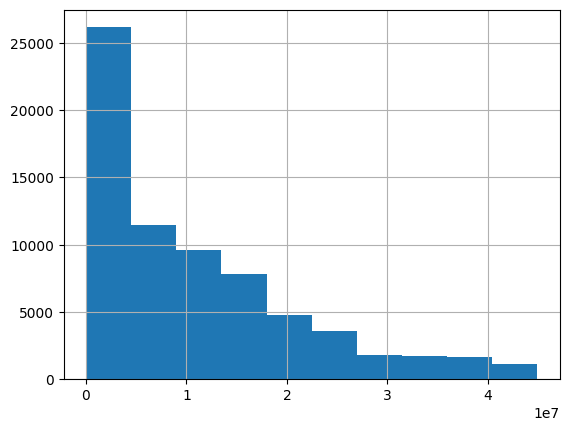

In [12]:
train_data["price"].hist()

In [4]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

train_data["price"] = np.log10(train_data["price"])

label_transformer = KBinsDiscretizer(n_bins=5, encode="ordinal", random_state=0)
label_transformer.fit(train_data[["price"]])

train_data["price"] = label_transformer.transform(train_data[["price"]])
train_data["price"] = train_data["price"].astype(int)
train_data["price"]

44749     1
128534    4
29224     2
89063     0
42944     1
         ..
30618     0
69578     2
64395     3
65830     4
108078    4
Name: price, Length: 69649, dtype: int32

<Axes: >

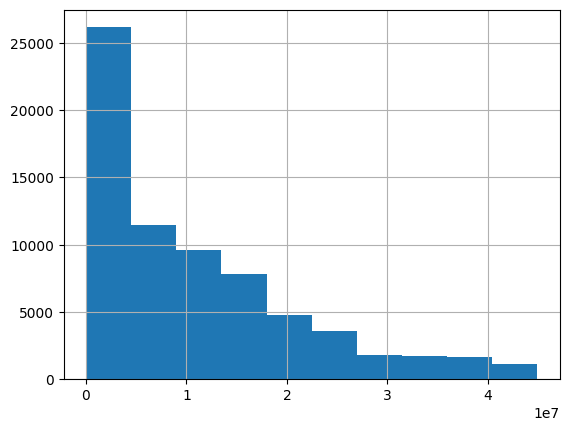

In [13]:
train_data["price"].hist()

In [14]:
features = ["baths", "bedrooms", "city", "Area_in_Marla"]
train_data[features]

,baths,bedrooms,city,Area_in_Marla
44749,2,2,Karachi,3.6
128534,5,5,Lahore,10.0
29224,3,4,Islamabad,7.0
89063,2,2,Islamabad,5.0
42944,2,2,Islamabad,3.6
...,...,...,...,...
30618,2,2,Islamabad,6.2
69578,2,2,Lahore,5.0
64395,5,5,Lahore,6.0
65830,7,5,Lahore,20.0


In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

def create_pipeline():
    return make_pipeline(
        make_column_transformer(
            (HashingVectorizer(n_features=5), "city"),
            (StandardScaler(), ["Area_in_Marla"]),
            remainder="passthrough"),
        
        # LinearRegression()
        RandomForestRegressor(n_estimators=10, random_state=0)
        # SGDRegressor(random_state=0)
    )

pipeline = create_pipeline()
pipeline



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hashingvectorizer',
                                                  HashingVectorizer(n_features=5),
                                                  'city'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Area_in_Marla'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10, random_state=0))])

In [16]:
pipeline.fit(train_data[features], train_data["price"])
pipeline.score(train_data[features], train_data["price"])

0.5068657082365251

In [20]:
# test_data["price"] = np.log10(test_data["price"])
# test_data["price"] = label_transformer.transform(test_data[["price"]].values.reshape(-1, 1))
pipeline.score(test_data[features], test_data["price"])

0.4533632549057105

In [21]:
sample = test_data.sample(random_state=0)
sample

,property_type,price,location,city,baths,purpose,bedrooms,Area_in_Marla
160,House,13000000,Gadap Town,Karachi,4,For Sale,4,9.6


In [22]:
price = pipeline.predict(sample)[0]
price

16653179.910022084

In [23]:
sample = {"baths": 2, "bedrooms": 2, "city": "Islamabad", "Area_in_Marla": 4.0}
sample = pd.DataFrame([sample])
sample

,baths,bedrooms,city,Area_in_Marla
0,2,2,Islamabad,4.0


In [24]:
price = pipeline.predict(sample)[0]
price

3057363.1136832703

In [26]:
sample = pd.DataFrame([{"baths": 3, "bedrooms": 5, "city": "bangkok", "Area_in_Marla": 10.0}])
pipeline.predict(sample)[0]

15192842.857142856